## Условие задачи:

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Нам предстоит построить модель, которая предскажет температуру стали.

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.


### План работы:
    
- Импортируем данные, проведем исследовательский анализ данных.<
- Проведем предобработку данных

- Подготоим данные:
    - Определим признаки необхимые нам для нашей будущей модели
    - Удалим ненужные данные, если найдем такие
    
    
- Соединим все нужные данные в одну таблицу по key
- Будем использовать LinearRegression, CatBoost, LightGBM с подбором лучших гиперпараметров
- Сравним полученные результаты наших моделей и выделим лучшую
- Проверим на тестовой выборке
- Напишем отчет


## Исследовательский анализ данных

In [1]:
# Импортируем всё нужное и ненужное
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')



### Загрузка и обзор данных

In [2]:
#загрузим данные на любой платформе
try:
    df_arc = pd.read_csv('data_arc.csv')
    df_bulk = pd.read_csv('data_bulk.csv')
    df_bulk_time = pd.read_csv('data_bulk_time.csv')
    df_gas = pd.read_csv('data_gas.csv')
    df_temp = pd.read_csv('data_temp.csv')
    df_wire = pd.read_csv('data_wire.csv')
    df_wire_time = pd.read_csv('data_wire_time.csv')
except:
    df_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
    df_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
    df_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
    df_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
    df_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
    df_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
    df_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')
display(df_arc.head())
display(df_bulk.head())
display(df_bulk_time.head())
display(df_gas.head())
display(df_temp.head())
display(df_wire.head())
display(df_wire_time.head())

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# посмотрим на них. Будет TLDR, но зато всё одним разом
pd.set_option('display.max_rows', None) #датафрейм большой, сделаем, чтобы смотрелись все столбцы
names = [df_arc, df_bulk, df_bulk_time, df_gas, df_temp, df_wire, df_wire_time]
def info_func(names):
    for name in names:
        df_temp = pd.DataFrame(name)
        display(df_temp.head(10))
        display(df_temp.info())
        display('Кол-во дублей:', df_temp.duplicated().sum())
        display('Кол-во НАНов:', df_temp.isna().sum())
        display('Статистика:', df_temp.describe(),
              '=======================================================================================================')
    return
info_func(names)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

'Кол-во дублей:'

0

'Кол-во НАНов:'

key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64

'Статистика:'

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


'======================================================================================================='

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

'Кол-во дублей:'

0

'Кол-во НАНов:'

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

'Статистика:'

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


'======================================================================================================='

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
5,6,NaN,NaN,NaN,2019-05-03 13:59:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:53:27,NaN,2019-05-03 13:53:27,2019-05-03 13:53:27
6,7,NaN,NaN,NaN,2019-05-03 14:29:14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:22:19,NaN,2019-05-03 14:22:19,2019-05-03 14:22:19
7,8,NaN,NaN,NaN,2019-05-03 15:04:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:55:46,NaN,2019-05-03 14:55:46,2019-05-03 14:55:46
8,9,NaN,NaN,NaN,2019-05-03 15:47:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:41:00,NaN,2019-05-03 15:41:00,2019-05-03 15:41:00
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:18:52,NaN,2019-05-03 16:18:52,2019-05-03 16:18:52


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

'Кол-во дублей:'

0

'Кол-во НАНов:'

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

'Статистика:'

,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


'======================================================================================================='

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

'Кол-во дублей:'

0

'Кол-во НАНов:'

key      0
Газ 1    0
dtype: int64

'Статистика:'

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


'======================================================================================================='

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


None

'Кол-во дублей:'

0

'Кол-во НАНов:'

key                0
Время замера       0
Температура     2901
dtype: int64

'Статистика:'

,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


'======================================================================================================='

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

'Кол-во дублей:'

0

'Кол-во НАНов:'

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

'Статистика:'

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


'======================================================================================================='

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:59:02,2019-05-03 13:59:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:28:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:03:42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:42:43,2019-05-03 15:58:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:20:25,2019-05-03 16:21:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

'Кол-во дублей:'

0

'Кол-во НАНов:'

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

'Статистика:'

,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


'======================================================================================================='

### Обработка данных

В данных имеются аномалии, с которыми нужно разбираться в индивидуальном порядке. В индивидуальном порядке и пойдём

#### df_arc

- Некорректный тип данных у  "Начало нагрева дугой" и "Конец нагрева дугой". Изменим на `datetime`.
- Имеем аномальное значение `-715` Реактивной мощности. Вероятно это ошибка

In [4]:
#Изменим тип данных на datetime
df_arc['Начало нагрева дугой'] = pd.to_datetime(df_arc['Начало нагрева дугой'])
df_arc['Конец нагрева дугой'] = pd.to_datetime(df_arc['Конец нагрева дугой'])

In [5]:
#Посмотрим на графики. Сделаем собсвтенную функцию для рисования в одном стиле
def graph(data, parameter, bins=40):
        fig = plt.figure(figsize=(12, 6), dpi= 80)
        grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.2)
        ax_main = fig.add_subplot(grid[:-1, :-1])
        ax_right = fig.add_subplot(grid[:-1, -1])  
        sns.distplot(data[parameter], ax=ax_main)
        sns.boxplot(data[parameter], ax=ax_right)
        ax_right.grid(axis='y')
        ax_main.set(title='График '+parameter)
        ax_main.axvline(np.mean(data[parameter]),color='r', linestyle='--', label='Среднее')
        ax_main.axvline(np.median(data[parameter]),color='r', linestyle='-', label='Медиана')
        ax_main.legend()
        fig.show()        

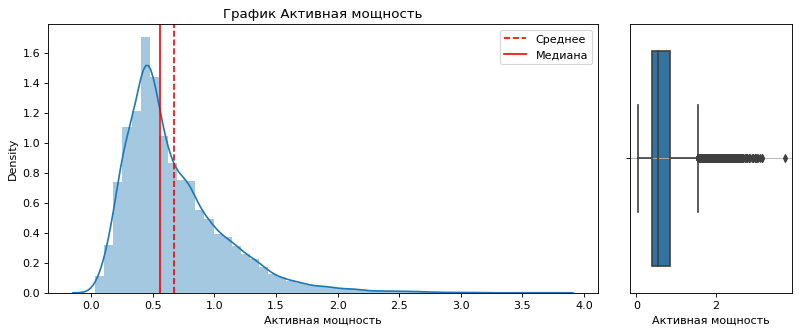

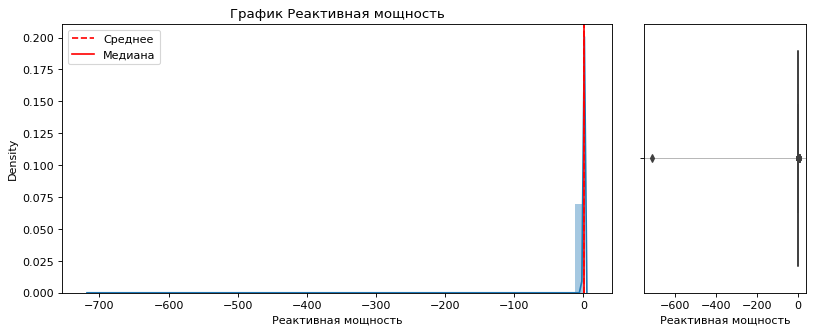

In [6]:
graph(df_arc,'Активная мощность')
graph(df_arc, 'Реактивная мощность')

С реактивной мощностью действительно есть проблемы. Попробуем от них избавиться

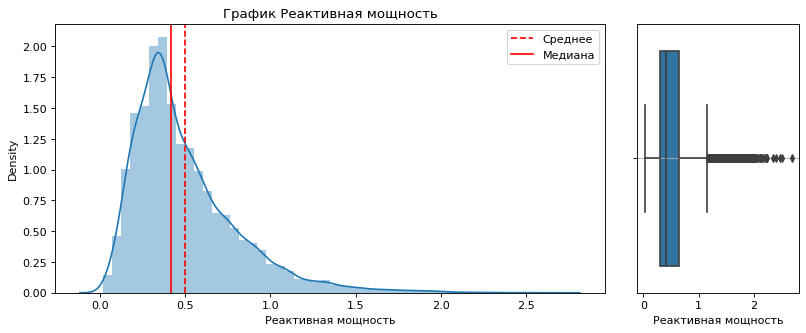

In [7]:
df_arc = df_arc[df_arc['Реактивная мощность'] >= 0]
graph(df_arc, 'Реактивная мощность')

Теперь похоже на правду. Оставим так

Учитывая то, что перед нами стоит задача по снижению количества потребляемой энергии в целом, то логично объединить две составляющие в одну, тем более, есть соотвествующая формула (https://ru.wikipedia.org/wiki/%D0%AD%D0%BB%D0%B5%D0%BA%D1%82%D1%80%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_%D0%BC%D0%BE%D1%89%D0%BD%D0%BE%D1%81%D1%82%D1%8C#%D0%9F%D0%BE%D0%BB%D0%BD%D0%B0%D1%8F_%D0%BC%D0%BE%D1%89%D0%BD%D0%BE%D1%81%D1%82%D1%8C)
$$ S=\sqrt{P^2+Q^2} $$
где: $P$ — активная мощность, $Q$ — реактивная мощность

In [8]:
# Посчитаем
def full_power(row):
    full_power = math.sqrt(row['Активная мощность']**2 + row['Реактивная мощность']**2)
    return full_power
df_arc['Полная мощность'] = df_arc.apply(full_power, axis=1)

На этом подготовку данного датасета можно завершать, переходим к следующему

#### df_temp

В данном датасете есть проблемы с типом данных и пропусками

In [9]:
# Изменим тип данных у времени замера
df_temp['Время замера'] = pd.to_datetime(df_temp['Время замера'])

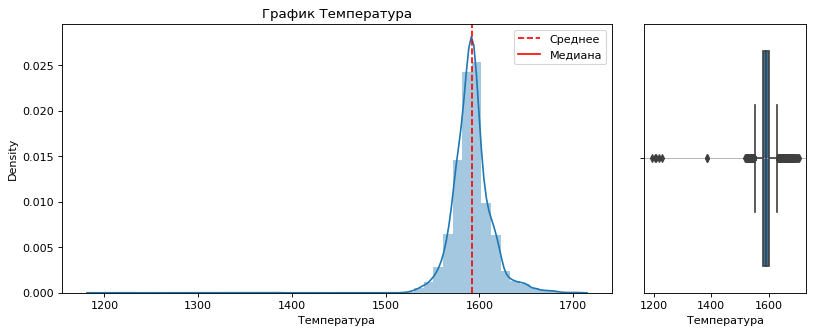

In [10]:
# Посмотрим на распределение температуры
graph(df_temp, 'Температура')

In [11]:
# Посмотрим на пропуски
df_temp[df_temp['Температура'].isnull()].head(10)

,key,Время замера,Температура
12268,2500,2019-08-06 03:24:43,NaN
12269,2500,2019-08-06 03:25:16,NaN
12270,2500,2019-08-06 03:28:21,NaN
12272,2501,2019-08-06 04:01:59,NaN
12273,2501,2019-08-06 04:14:35,NaN
12274,2501,2019-08-06 04:22:14,NaN
12275,2501,2019-08-06 04:31:14,NaN
12277,2502,2019-08-06 04:46:04,NaN
12278,2502,2019-08-06 04:52:32,NaN
12279,2502,2019-08-06 04:57:30,NaN


Пропуски начинаются с партии 2500, ограничим нашу выборку данными до этой партии при объединении данных

In [12]:
# Очистим пропуски в данных в таблице df_temp
df_temp = df_temp.dropna(subset=['Температура']).reset_index(drop=True)
df_temp = df_temp.sort_values(by=['Время замера'])

In [13]:
# Также можно убрать информацию о партиях по которым известно только одно измерение температуры.
count = df_temp.groupby(by = 'key', as_index = False).count()
one = count[count['Время замера'] == 1]['key'].tolist()
df_temp = df_temp.query('key not in @one')

In [14]:
# Для нашей задачи также будет полезно зафиксировать начальную и конечную температуру для партии
df_temp = df_temp.groupby(by = 'key').agg(['first', 'last']).reset_index()
df_temp.columns = df_temp.columns.droplevel()
df_temp.columns = ['key', 'Время замера 1', 'Время замера 2', 'Температура 1', 'Температура 2']
df_temp = df_temp[['key', 'Температура 1', 'Температура 2']]
df_temp.head(5)

,key,Температура 1,Температура 2
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0


#### Остальные датасеты

##### df_bulk

- Типы данных указаны верно. Дубликаты отсутствуют.
- Есть большое количество пропущенных значений в датасете, вероятно из-за того, что для каждой партии добавляют опредленное сочетание сыпучих материалов.
- дополнительно посмотрим на диаграммы размаха

Text(0.5, 1.0, 'Диаграмма размаха для сыпучих материалов')

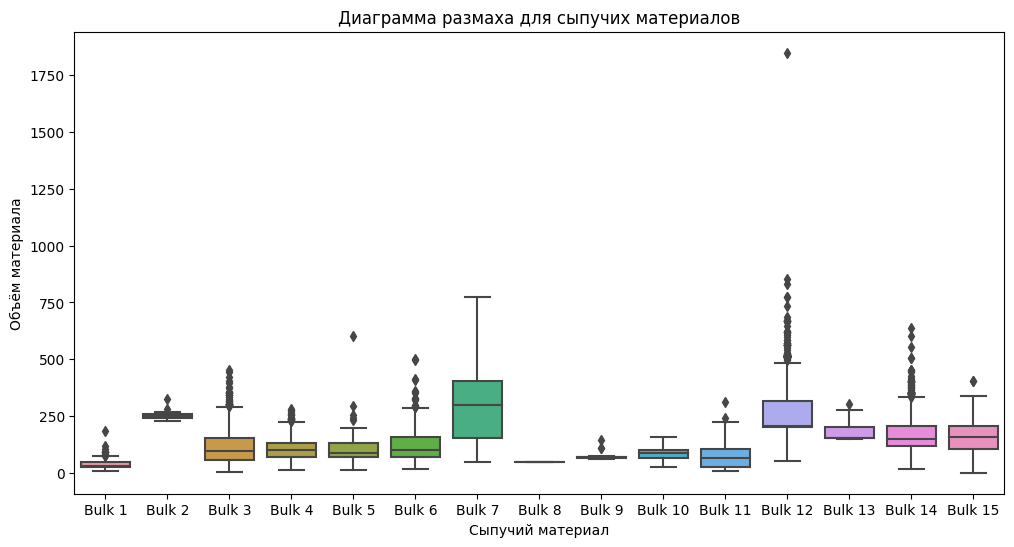

In [15]:
fig = plt.figure(figsize=(12,6))
sns.boxplot(data=df_bulk.drop('key', axis=1))
plt.xlabel("Сыпучий материал")
plt.ylabel("Объём материала")
plt.title("Диаграмма размаха для сыпучих материалов")

Из диаграммы размаха видно, что существенные выбросы имеются только для присадок 5 и 12. Вполне возможно, что данные партии потребовали большее количество сыпучих материлов по сравнению со всеми остальными, поэтому удалять такие выбросы может быть вредно.

##### df_bulk_time

- Наблюдаем большое количество пропущенных значений в датасете
- Дубликатов нет 
- Есть типы данных, которые нужно исправить
- В построении нашей будущей модели данный датасет использовать не будем, поэтому нет необходимости проводить его предобработку

##### df_gas

- Дубликатов не имеем, типы данных указаны верно. 
- Незаполненныз значений не имеем

##### df_wire

- Дубликатов не имеем 
- Имеются пустые значения в датасете, скорее всего они пустые потому что различные виды проволочных материалов поступали в разных пропорциях в разные промежутки времени.
- Типы данных указаны верно

Text(0.5, 1.0, 'Диаграмма размаха для проволочных материалов')

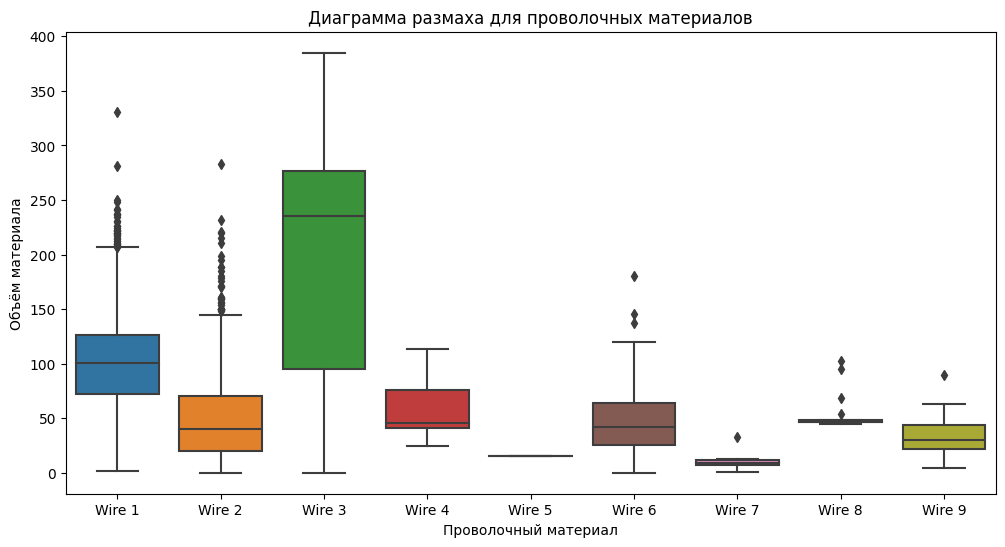

In [16]:
fig = plt.figure(figsize=(12,6))
sns.boxplot(data=df_wire.drop('key', axis=1))
plt.xlabel("Проволочный материал")
plt.ylabel("Объём материала")
plt.title("Диаграмма размаха для проволочных материалов")

Здесь также как и с df_bulk сложно что-то говорить, т.к. данных о сценариях применения того или иного вида добавки у нас нет. Явных и объяснимых аномалий не имеем, поэтому оставил как есть 

##### df_wire_time

- Дубликатов не имеется
- Имеются пустые значения
- Типы данных в Wire 1 указаны неверно, но менять их не будем, т.к. данный датасет использовать в дальнейшем не будем.

### Объединение данных

In [17]:
# введём дополнительный признак общего времени нагрева
df_arc['Общее время нагрева дугой'] = df_arc['Конец нагрева дугой'] - df_arc['Начало нагрева дугой']
df_arc['Общее время нагрева дугой'] = df_arc['Общее время нагрева дугой'].dt.seconds

In [18]:
# определим количество нагревов в рамках одной партии
df_arc_c = df_arc.groupby(by = 'key', as_index = False).count()[['key', 'Начало нагрева дугой']]
df_arc_c.columns = ['key', 'Количество итераций нагрева']

# сгруппируем данные по партиям
df_arc = df_arc.groupby(by = 'key', as_index = False).sum()

# добавим информацию о количестве итераций нагрева по ключу key
df_arc = df_arc.merge(df_arc_c, how = 'left', on = 'key')

In [19]:
# Поcле 2500 партии значения температуры есть только для первого измерения. 
# Поэтому будем использовать только партии до 2500 номера.
df_temp = df_temp.query('key < 2500')
df_arc = df_arc.query('key < 2500')
df_bulk = df_bulk.query('key < 2500')
df_wire = df_wire.query('key < 2500')

In [20]:
# объединим обработанные датасеты по ключу key
df = (df_temp.merge(df_arc, how = 'inner', on = 'key')
                 .merge(df_wire, how = 'inner', on = 'key')
                 .merge(df_bulk, how = 'inner', on = 'key')
                 .merge(df_gas, how = 'inner', on = 'key')
       )


# заполним пропуски образовавшиеся после объединения таблиц нулями
df = df.fillna(0)

# переименуем столбцы для корректной работы lgbm
df = df.rename(columns={'Температура 1': 'First_temp',
                            'Температура 2': 'Last_temp',
                            'Полная мощность': 'Full_power',
                            'Количество итераций нагрева':'Heating_iterations', # тут вопрос, значение явно будет коррелировать с количеством иетарций нагрева, попробую поменять их во время экспериментов. пока оставим количество нагревов
                            'Газ 1': 'Gas'})

# уберем колонку-индентификатор key и лишнии столбцы, которые, вероятно будут коррелировать с новыми признаками
df = df.drop(['key', 'Активная мощность', 'Реактивная мощность', 'Общее время нагрева дугой'], axis = 1)
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   First_temp          2329 non-null   float64
 1   Last_temp           2329 non-null   float64
 2   Full_power          2329 non-null   float64
 3   Heating_iterations  2329 non-null   int64  
 4   Wire 1              2329 non-null   float64
 5   Wire 2              2329 non-null   float64
 6   Wire 3              2329 non-null   float64
 7   Wire 4              2329 non-null   float64
 8   Wire 5              2329 non-null   float64
 9   Wire 6              2329 non-null   float64
 10  Wire 7              2329 non-null   float64
 11  Wire 8              2329 non-null   float64
 12  Wire 9              2329 non-null   float64
 13  Bulk 1              2329 non-null   float64
 14  Bulk 2              2329 non-null   float64
 15  Bulk 3              2329 non-null   float64
 16  Bulk 4

,First_temp,Last_temp,Full_power,Heating_iterations,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,...,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Gas
0,1571.0,1613.0,5.826395,5,60.059998,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986
1,1581.0,1602.0,3.649216,4,96.052315,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561
2,1596.0,1599.0,2.989534,5,91.160157,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793
3,1601.0,1625.0,3.814962,4,89.063515,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219
4,1576.0,1602.0,4.035758,4,89.238236,9.114560,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692
5,1543.0,1596.0,4.786837,4,99.109917,9.114560,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,204.0,0.0,201.0,154.0,11.273392
6,1586.0,1599.0,2.987777,4,98.061600,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,204.0,0.0,152.0,154.0,9.836267
7,1577.0,1598.0,4.627389,4,155.282394,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,410.0,0.0,252.0,153.0,15.171553
8,1587.0,1592.0,2.555348,5,113.393279,9.143681,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,107.0,0.0,99.0,203.0,8.216623
9,1574.0,1593.0,3.851739,6,81.244796,12.376000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,203.0,0.0,102.0,204.0,6.529891


### Проверка на мультиколлинеарность

In [21]:
# подготовим датафрейм для VIF
df1 = df.drop('Last_temp', axis=1)
vif_data = pd.DataFrame()
vif_data["feature"] = df1.columns
  
# посчитаем VIF для каждого признака
vif_data["VIF"] = [variance_inflation_factor(df1.values, i)
                          for i in range(len(df1.columns))]
  
print(vif_data)

               feature        VIF
0           First_temp  16.806599
1           Full_power  18.932554
2   Heating_iterations  26.237948
3               Wire 1   9.010783
4               Wire 2   1.554393
5               Wire 3   1.143003
6               Wire 4   3.472040
7               Wire 5        NaN
8               Wire 6   1.535593
9               Wire 7   1.626134
10              Wire 8  57.180522
11              Wire 9   1.072001
12              Bulk 1   1.476992
13              Bulk 2   2.872681
14              Bulk 3   1.623648
15              Bulk 4   1.998528
16              Bulk 5   1.184824
17              Bulk 6   1.518391
18              Bulk 7   2.729591
19              Bulk 8   3.717706
20              Bulk 9  67.701291
21             Bulk 10   1.137037
22             Bulk 11   1.101702
23             Bulk 12   7.436426
24             Bulk 13   1.058804
25             Bulk 14   7.850682
26             Bulk 15   5.392914
27                 Gas   5.948693


<AxesSubplot:>

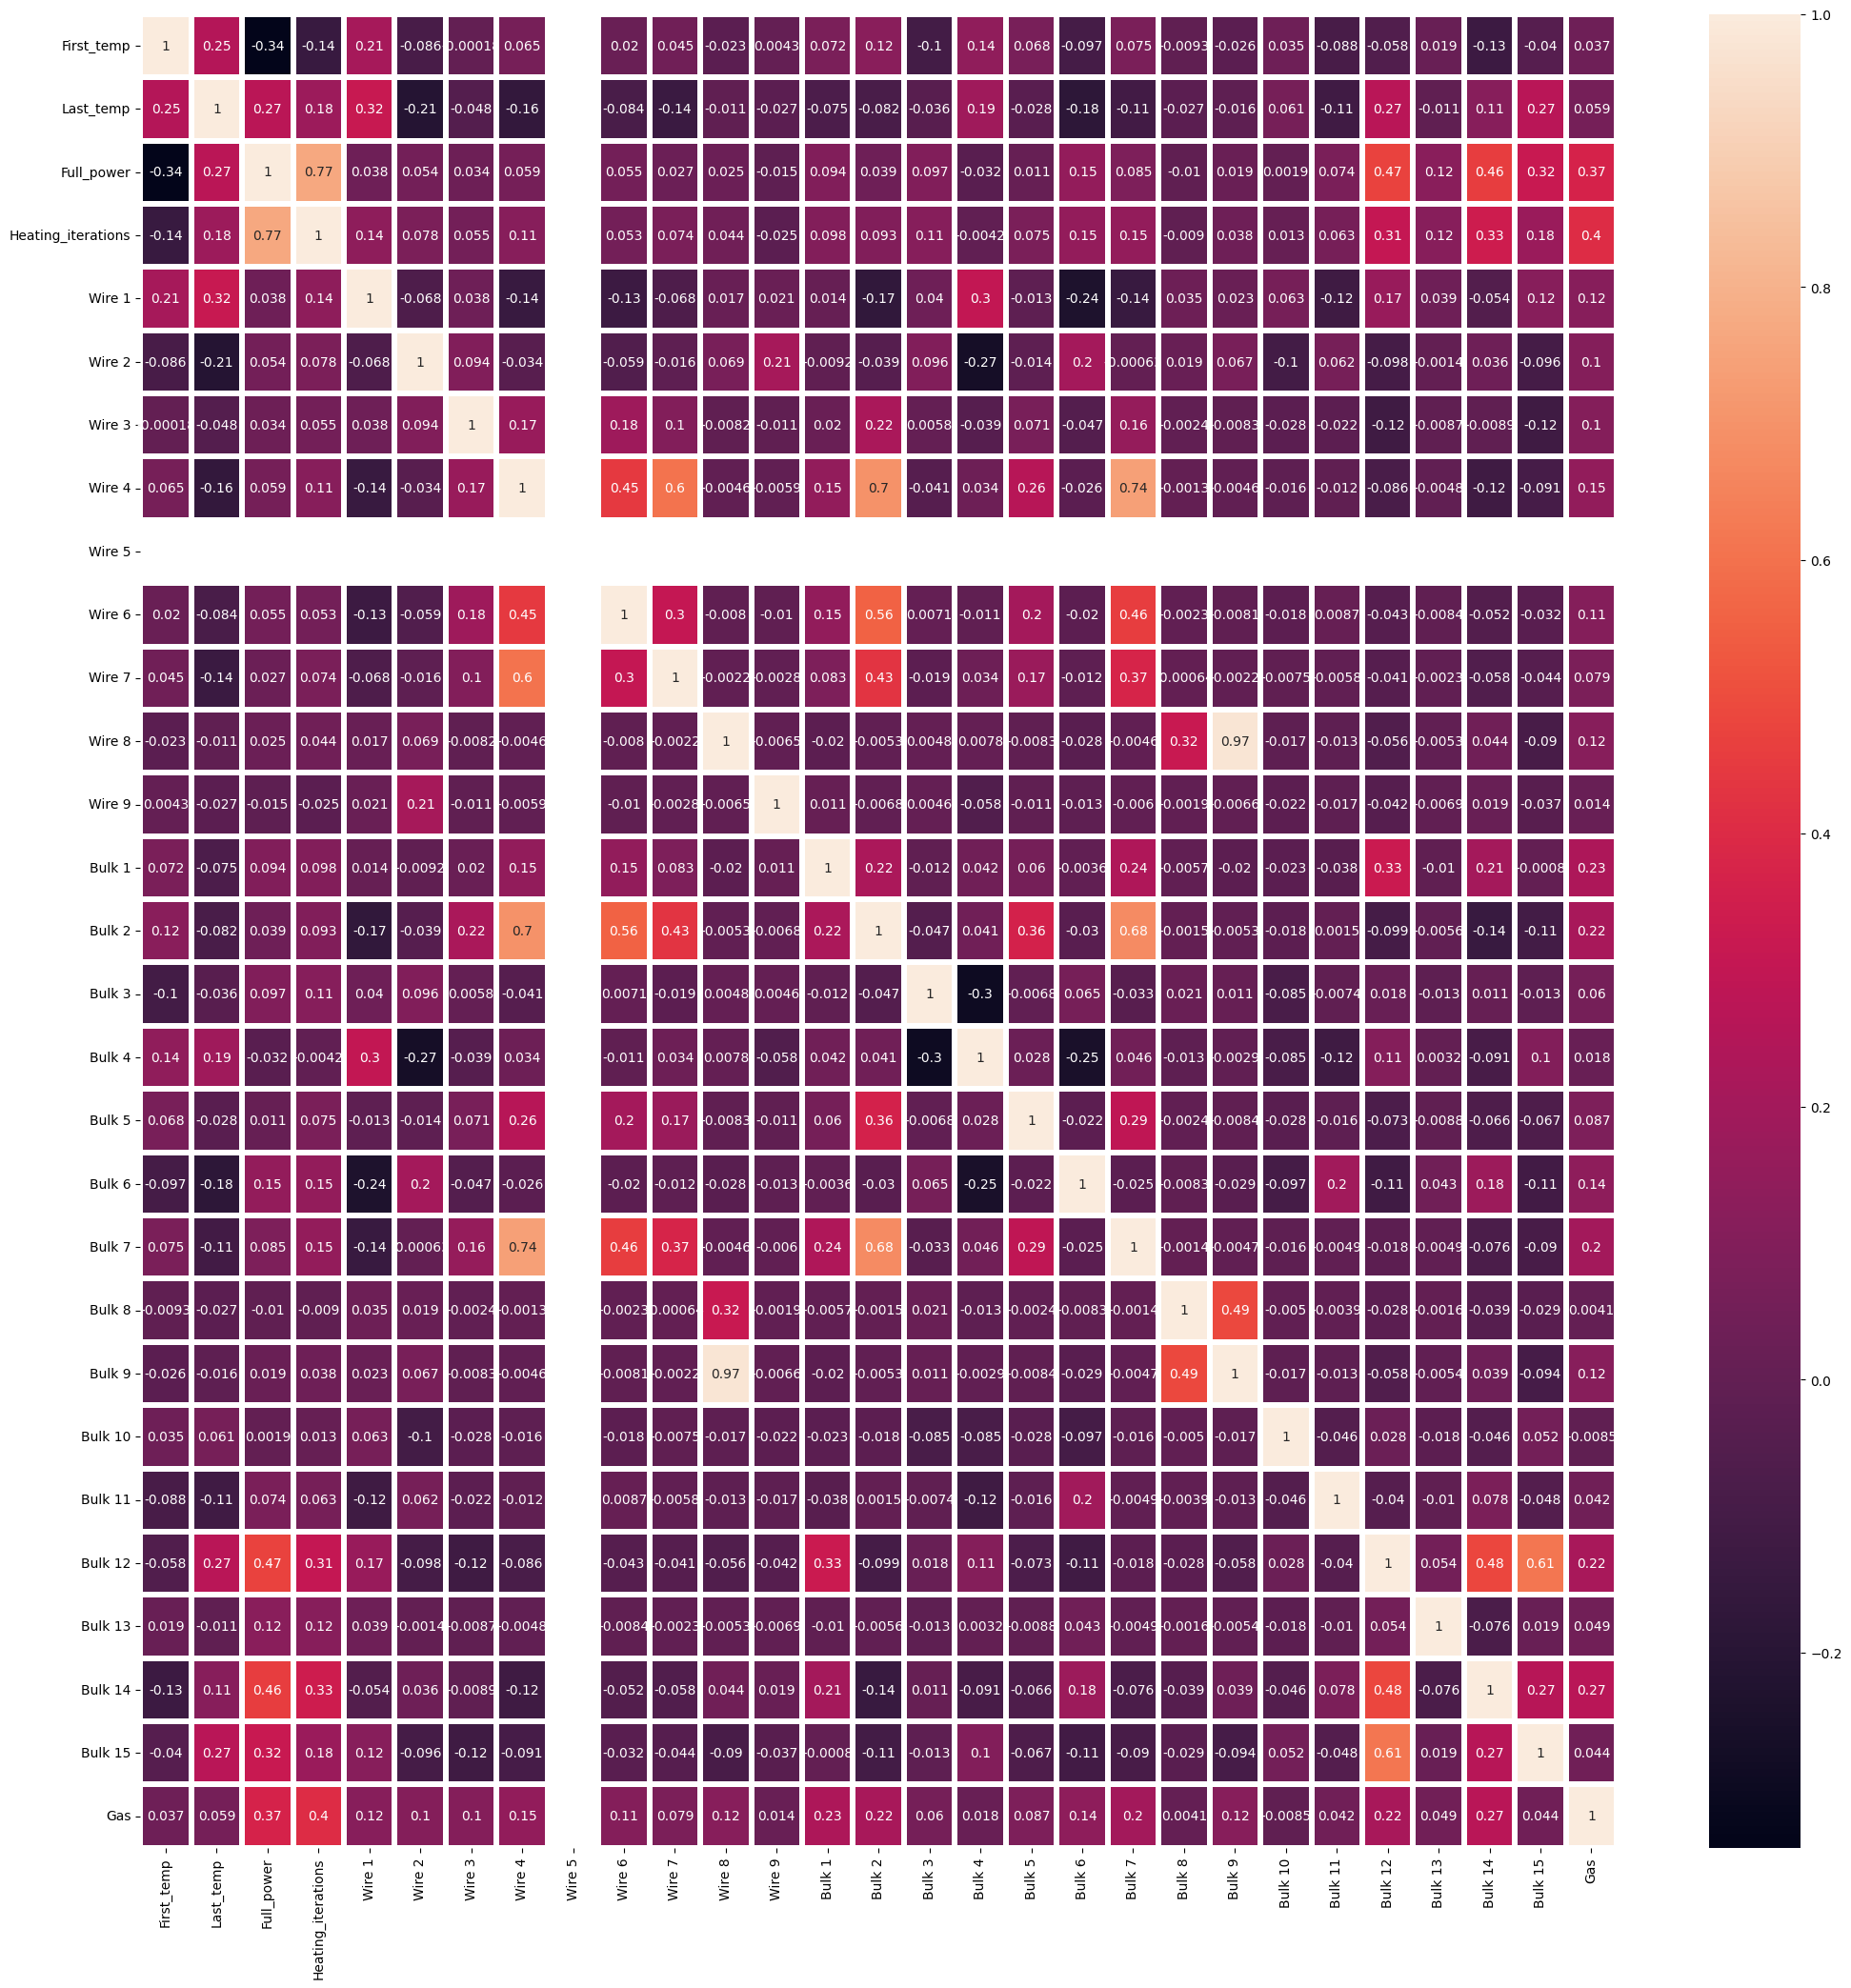

In [22]:
plt.rcParams['figure.figsize'] = (25, 25)
sns.heatmap(df.corr(), annot=True, linewidths=3, linecolor='white')

In [23]:
corr_table = df.corr().unstack().sort_values().drop_duplicates()

corr_table[(corr_table > 0.9) | (corr_table < -0.9)]

Wire 8      Bulk 9        0.974969
First_temp  First_temp    1.000000
dtype: float64

#### Выводы
Обнаружили весьма высокую мультиколлинеарность по значениям VIF между Bulk 9 и Wire 8, также имеем пропуски по столбцу Wire 5. Из финального датасета удалим Bulk 9 и Wire 5

In [24]:
df = df.drop(['Bulk 9', 'Wire 5'] , axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   First_temp          2329 non-null   float64
 1   Last_temp           2329 non-null   float64
 2   Full_power          2329 non-null   float64
 3   Heating_iterations  2329 non-null   int64  
 4   Wire 1              2329 non-null   float64
 5   Wire 2              2329 non-null   float64
 6   Wire 3              2329 non-null   float64
 7   Wire 4              2329 non-null   float64
 8   Wire 6              2329 non-null   float64
 9   Wire 7              2329 non-null   float64
 10  Wire 8              2329 non-null   float64
 11  Wire 9              2329 non-null   float64
 12  Bulk 1              2329 non-null   float64
 13  Bulk 2              2329 non-null   float64
 14  Bulk 3              2329 non-null   float64
 15  Bulk 4              2329 non-null   float64
 16  Bulk 5

### План работы

- На данном этапе имеем большую таблицу с данными
- Предварительно определён признак, который будем пытаться предсказывать - Last_temp
- Далее проведём разделение данных на тестовую и обучающую выборки
- Масштабируем признаки, т.к. имеем дело в основном с количественными данными
- Обучим разные модели и оценим их качество.
- Выберем одну единственную и прогоним на ней тестовые данные, в надежде получить удовлетворительный MAE. Также посмотрим Feature Importance.

## Обучение моделей

Далее проведём разделение данных на тестовую и обучающую выборки
Масштабируем признаки, т.к. имеем дело в основном с количественными данными
Обучим разные модели и оценим их качество.
Выберем одну единственную и прогоним на ней тестовые данные, в надежде получить удовлетворительный MAE. Также посмотрим Feature Importance.

### Подготовка данных

In [25]:
# Разделим нашу датасет на тестовую и обучающие выборки
random_seed = 12092022 #согласно условию задания
train, test = train_test_split(df, test_size = .20, random_state = random_seed)

In [26]:
# Масштабируем количественные признаки
numeric = df.columns.tolist()
numeric = [i for i in numeric if i not in ('Last_temp')]
scaler = MinMaxScaler()
scaler.fit(train[numeric])

# Масштабируем обучающую выборку
train[numeric] = scaler.transform(train[numeric])

# Масштабируем тестовую выборку
test[numeric] = scaler.transform(test[numeric])

print('Размер обучающей выборки:', train.shape)
print('Размер тестовой выобрки:', test.shape)

Размер обучающей выборки: (1863, 27)
Размер тестовой выобрки: (466, 27)


In [27]:
# Определим target и features для обучающей выборки
features_train = train.drop(['Last_temp'], axis = 1)
target_train = train['Last_temp']

# Определим target и features для тестовой выборки
features_test = test.drop(['Last_temp'], axis = 1)
target_test = test['Last_temp']

### Обучение моделей и подбор гиперпараметров

Будем пробовать обучить модели линейной регрессии, LGBM и CatBoost

In [28]:
# Модели какие будем использовать 

models = {
    'CatBoostRegressor': CatBoostRegressor(),
    'LGBMRegressor': lgb.LGBMRegressor(),
    'LinearRegression': LinearRegression()
}


# Параметры для каждой модели для перебора GridSearchCV
params = {
    'LinearRegression':{
            'fit_intercept' : [True, False],
            'normalize':[True,False]
    },
    
    'CatBoostRegressor':{
          'loss_function':['MAE'], 
          'learning_rate': np.arange(0.03, 0.12, 0.02),
          'iterations': [150, 500],
          'random_state': [random_seed],
          'depth': np.arange(3, 7)
    },        

    'LGBMRegressor': {
        'boosting_type': ['gbdt', 'dart', 'goss', 'rf'],
        'n_estimators': [300, 100, 800],
        'num_leaves': [60, 31, 91], 
        'learning_rate':[0.001, 0.01, 0.02, 0.03],
        'random_state': [random_seed], 
        'metric': ['mae']
        }
}

In [29]:
# Максимально автоматизировать перебор параметров и моделей поможет собственная функция
def fit_score(train_features, train_targets):
    for name in models.keys():
        est = models[name]
        est_params = params[name]
        gscv = GridSearchCV(estimator=est, param_grid=est_params, n_jobs=-1, cv=5)
        gscv.fit(train_features, train_targets)
        train_predictions = gscv.predict(features_train)
        predictions = gscv.predict(features_test)
        result_list.append({
        'model': name,
        'train_mae_score': mean_absolute_error(target_train, train_predictions),
        'test_mae_score': mean_absolute_error(target_test, predictions),
        'best_params': gscv.best_params_
        })

In [30]:
'''%%time
result_list = []
fit_score(features_train, target_train)'''

'%%time\nresult_list = []\nfit_score(features_train, target_train)'

In [31]:
'''results = pd.DataFrame(result_list, columns=['model','train_mae_score','best_params'])
results.set_index("model", inplace = True)
pd.set_option("max_colwidth", 150)
results'''
results_perm = {
    'Модель': ['CatBoostRegressor','LGBMRegressor','LinearRegression'],
    'MAE Train': [3.872369, 4.678996, 6.336663],
    'Лучшие параметры': ['{depth: 5, iterations: 500, learning_rate: 0.07, loss_function: MAE, random_state: 12092022}','{boosting_type: goss, learning_rate: 0.03, metric: mae, n_estimators: 100, num_leaves: 91, random_state: 12092022}','{fit_intercept: True, normalize: True}']
}
results_perm_df = pd.DataFrame(results_perm)
pd.set_option("max_colwidth", 150)
results_perm_df

,Модель,MAE Train,Лучшие параметры
0,CatBoostRegressor,3.872369,"{depth: 5, iterations: 500, learning_rate: 0.07, loss_function: MAE, random_state: 12092022}"
1,LGBMRegressor,4.678996,"{boosting_type: goss, learning_rate: 0.03, metric: mae, n_estimators: 100, num_leaves: 91, random_state: 12092022}"
2,LinearRegression,6.336663,"{fit_intercept: True, normalize: True}"


Наилучшей моделью на тренировочной выборке оказалась CatBoost c параметрами depth: 5, iterations: 500, learning_rate: 0.07, loss_function: MAE, random_state: 12092022. Эту модель будем проверять на тестовых данных.

### Проверка на тестовой выборке

In [32]:
%%time
#С подобранными параметрами будем использовать модель CatBoost на тестовой выборке
model = CatBoostRegressor(depth=5, 
                          learning_rate = 0.07, 
                          loss_function = 'MAE', 
                          iterations=500, 
                          random_state = 12092022,
                          verbose = 0)

model.fit(features_train,target_train)
predictions = model.predict(features_test)
print('MAE на тестовой выборке:', mean_absolute_error(predictions,target_test))

MAE на тестовой выборке: 5.814018037586347
CPU times: total: 422 ms
Wall time: 701 ms


Считаем эксперимент удачным, модель CatBoost побивает психологическую отметку MAE < 6.0 на тестовой выборке

### Features importance
Тут посмотрим какие факторы оказали наибольшее влияние на нашу модель

Text(0.5, 1.0, 'Feature Importance')

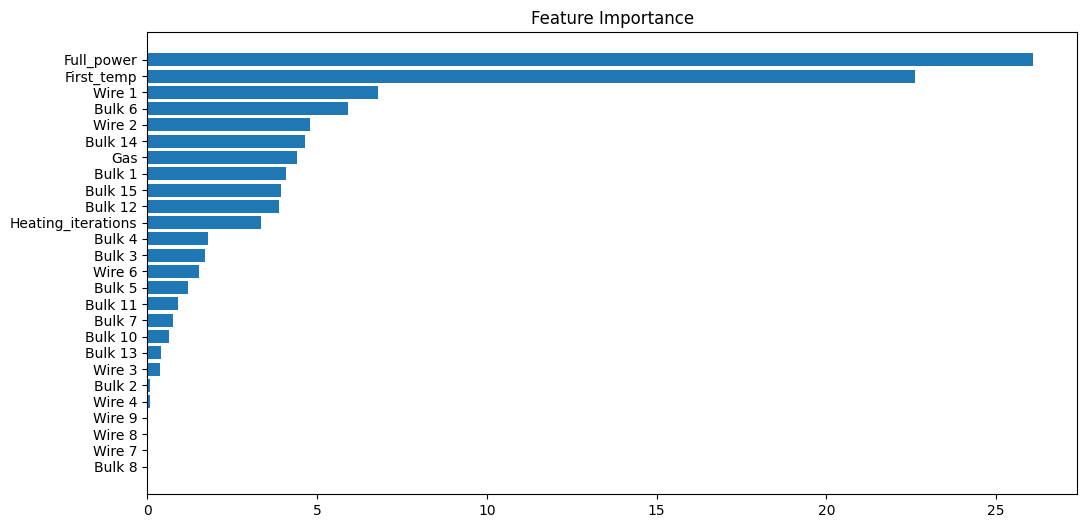

In [33]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(features_test.columns)[sorted_idx])
plt.title('Feature Importance')

#### *Отбросим лишнее
Посмотрим как изменится MAE при отбрасывании Bulk 7, Bulk 10, Bulk 13, Wire 3, Bulk 2, Wire 4, Wire 9, Wire 8, Wire 7, Bulk 8

In [34]:
features_train_1 = features_train.drop(columns = ['Bulk 7', 'Bulk 10', 'Bulk 13', 'Wire 3', 'Bulk 2', 'Wire 4', 'Wire 9', 'Wire 8', 'Wire 7', 'Bulk 8'])
features_test_1 = features_test.drop(columns = ['Bulk 7', 'Bulk 10', 'Bulk 13', 'Wire 3', 'Bulk 2', 'Wire 4', 'Wire 9', 'Wire 8', 'Wire 7', 'Bulk 8'])

In [35]:
%%time
model_1 = CatBoostRegressor(depth=5, 
                          learning_rate = 0.07, 
                          loss_function = 'MAE', 
                          iterations=500, 
                          random_state = 12092022,
                          verbose = 0)

model_1.fit(features_train_1,target_train)
predictions_1 = model_1.predict(features_test_1)
print('MAE на тестовой выборке:', mean_absolute_error(predictions_1,target_test))

MAE на тестовой выборке: 5.872299074768167
CPU times: total: 438 ms
Wall time: 473 ms


Сэкономили около 13% времени, но потеряли 1% на точности. Возможно, данный подход можно будет использовать на значительно большем объёме данных

### Выводы
В данном разделе было проведено:

- Разделение данных на обучающий и тестовый наборы
- Масштабирование признаков
- Для обучения использовали 4 модели : CatBoostRegressor, LightGBMRegressor, LinearRegression
- Проведён подбор оптимальных гиперпараметров с помощью GridSearchCV
- Получен наилучший результат MAE 5.81 на тестовой выборке CatBoostRegressor
- Так же выявили признаки, которые больше всего влияют на модель это Начальная температура, Полная мощность и Wire 1
- *Проведён эксперимент по удалению самых неважных признаков из датасетов

Итого, можем заключить, что наша модель вполне работоспособна и предсказывает температуру с точностью в диапазоне от -5.81 до +5.81, что в масштабе температуры плавления стали (более 1400 градусов) вполне приемлемый результат 

## Отчёт о проделанной работе

В ходе работы над проектом перед нами стояла задача предсказания конечной температуры при обработке стали.

На этапе подготовки было проделанно следующее:
* Исследованны исходные данные

Обнаружено, что разделять реактивную и активную мощность нецелесообразно. Можно заменить 2 переменный 1-ой - Актвиная мощность

* Выявлены и удалены выбросы данных

В исследовании использовали только данные, где мощность > 0, и с отсутствием пропусков по замерам температуры

* Исследованны зависимости между данными

Обнаружили весьма высокую зависимость по значениям VIF между Bulk 9 и Wire 8. Для лучшей работы модели необходимо оставить лишь одну из переменных.

Во время разработки модели также были оценены и проранжированы наиболее важные факторы влияющие на предсказываемую переменную, а именно:

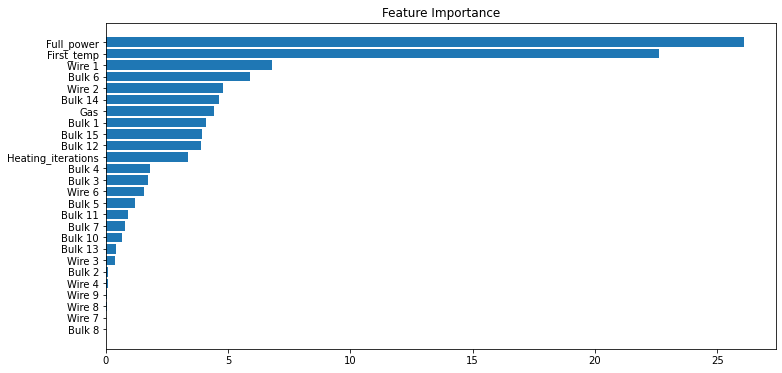

После моделеирования удалось достичь значения MAE на тестовой выборке = 5.814. Использованные параметры модели: depth: 5, iterations: 500, learning_rate: 0.07, loss_function: MAE, random_state: 12092022.